Loading data...
Dataset shape: (4311, 17)

Selected features: ['duration', 'contact', 'housing', 'loan', 'previous', 'pdays']
Target variable: y

Preprocessing data...
Feature info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4311 entries, 0 to 4310
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   duration  4311 non-null   int64 
 1   contact   4311 non-null   object
 2   housing   4311 non-null   object
 3   loan      4311 non-null   object
 4   previous  4311 non-null   int64 
 5   pdays     4311 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 202.2+ KB
None

Target distribution:
y
no     3813
yes     498
Name: count, dtype: int64

Categorical features: ['contact', 'housing', 'loan']
Numerical features: ['duration', 'previous', 'pdays']
Encoded contact: ['cellular' 'telephone' 'unknown']
Encoded housing: ['no' 'yes']
Encoded loan: ['no' 'yes']
Target encoded: ['no' 'yes']

Splitting data...
Training set

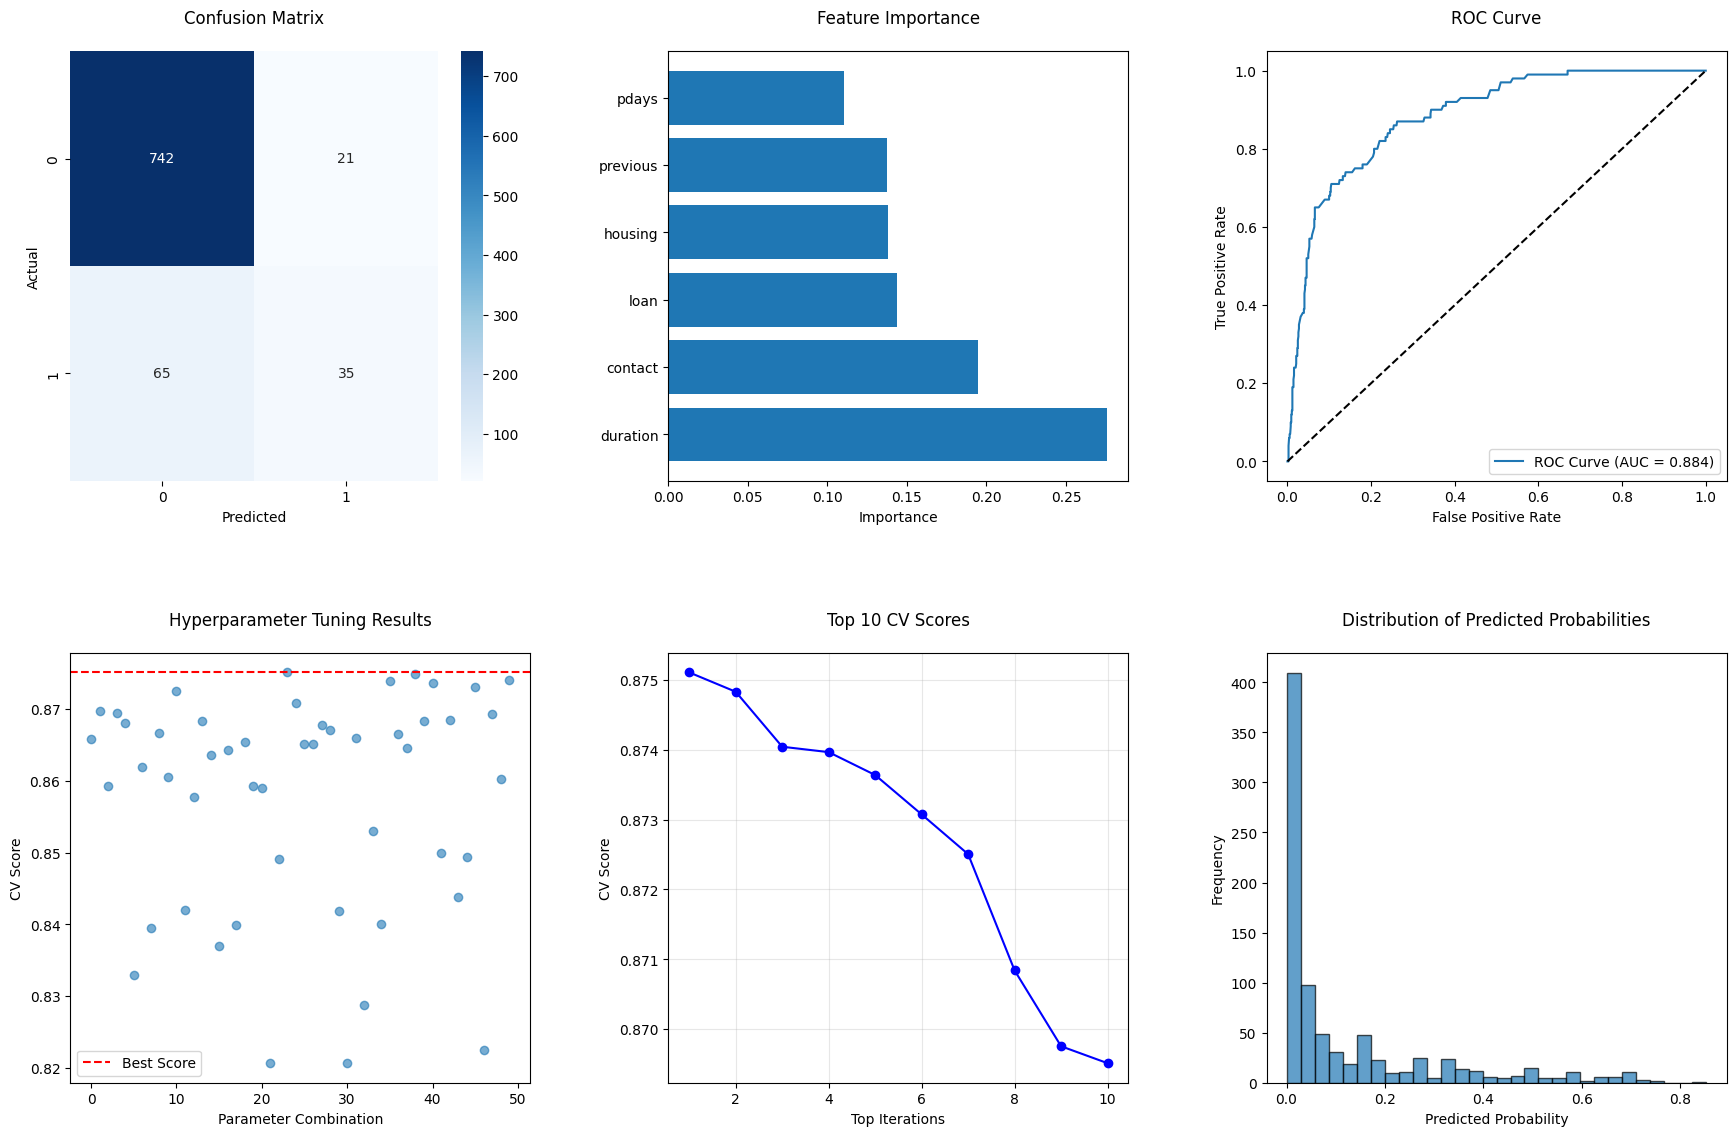


Cross-validation scores with best model:
CV Scores: [0.86428279 0.90089139 0.86432377 0.85339282 0.89066196]
Mean CV Score: 0.8747 (+/- 0.0359)

Saving the model...
Model saved as 'best_xgboost_model.pkl'
Label encoders saved as 'label_encoders.pkl'

FINAL SUMMARY
Best Model: XGBoost with automated hyperparameter tuning
Features used: 6 features
Training samples: 3448
Test samples: 863
Best CV Score: 0.8751
Test Accuracy: 0.9003
Test ROC-AUC: 0.8835
Most important feature: duration

Example prediction function created!
Use predict_new_data(best_model, label_encoders, your_data) to predict new samples


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Loading data...")
df = pd.read_csv('bank_cleaned.csv')
print(f"Dataset shape: {df.shape}")

selected_features = ['duration', 'contact', 'housing', 'loan', 'previous', 'pdays']
target = 'y'

print(f"\nSelected features: {selected_features}")
print(f"Target variable: {target}")

missing_features = [col for col in selected_features + [target] if col not in df.columns]
if missing_features:
    print(f"Missing columns: {missing_features}")
    print(f"Available columns: {list(df.columns)}")
    exit()

print("\nPreprocessing data...")

X = df[selected_features].copy()
y = df[target].copy()

print("Feature info:")
print(X.info())
print(f"\nTarget distribution:")
print(y.value_counts())

categorical_features = []
numerical_features = []

for col in selected_features:
    if X[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {le.classes_}")

if y.dtype == 'object':
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(y)
    print(f"Target encoded: {target_encoder.classes_}")

print("\nSplitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution:\n{pd.Series(y_train).value_counts()}")

print("\nSetting up hyperparameter tuning...")

param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

print("Starting hyperparameter tuning...")
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,       
    scoring='roc_auc',
    n_jobs=-1,  
    random_state=42,
    verbose=1
)

print("Training model with hyperparameter tuning (this may take a while)...")
random_search.fit(X_train, y_train)

print("\nBest hyperparameters found:")
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_

print("\nEvaluating model performance...")

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nFeature Importance:")
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=12, pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 2)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance', fontsize=12, pad=20)
plt.xlabel('Importance')

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.subplot(2, 3, 3)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=12, pad=20)
plt.legend()

plt.subplot(2, 3, 4)
cv_results = pd.DataFrame(random_search.cv_results_)
plt.scatter(range(len(cv_results)), cv_results['mean_test_score'], alpha=0.6)
plt.xlabel('Parameter Combination')
plt.ylabel('CV Score')
plt.title('Hyperparameter Tuning Results', fontsize=12, pad=20)
plt.axhline(y=random_search.best_score_, color='r', linestyle='--', label='Best Score')
plt.legend()

plt.subplot(2, 3, 5)
top_scores = cv_results.nlargest(10, 'mean_test_score')['mean_test_score'].values
plt.plot(range(1, 11), top_scores, 'bo-')
plt.xlabel('Top Iterations')
plt.ylabel('CV Score')
plt.title('Top 10 CV Scores', fontsize=12, pad=20)
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.hist(y_pred_proba, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities', fontsize=12, pad=20)

plt.tight_layout(pad=3.0)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

print("\nCross-validation scores with best model:")
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\nSaving the model...")
import joblib
joblib.dump(best_model, 'best_xgboost_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
print("Model saved as 'best_xgboost_model.pkl'")
print("Label encoders saved as 'label_encoders.pkl'")

print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)
print(f"Best Model: XGBoost with automated hyperparameter tuning")
print(f"Features used: {len(selected_features)} features")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Best CV Score: {random_search.best_score_:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")
print(f"Most important feature: {feature_importance.iloc[0]['feature']}")
print("="*50)

def predict_new_data(model, encoders, new_data_dict):
    """
    Function to predict new data
    
    Parameters:
    - model: trained XGBoost model
    - encoders: dictionary of label encoders
    - new_data_dict: dictionary with feature values
    
    Example:
    new_sample = {
        'duration': 200,
        'contact': 'cellular',
        'housing': 'no',
        'loan': 'no',
        'previous': 0,
        'pdays': -1
    }
    """
    new_df = pd.DataFrame([new_data_dict])
    
    for col in encoders.keys():
        if col in new_df.columns:
            new_df[col] = encoders[col].transform(new_df[col])
    
    prediction = model.predict(new_df)[0]
    probability = model.predict_proba(new_df)[0]
    
    return prediction, probability

print("\nExample prediction function created!")
print("Use predict_new_data(best_model, label_encoders, your_data) to predict new samples")